# Welcome to PathML!
### The following tutorial contains an overview of the PathML pre-processing transforms. These transforms can be combined into a custom pipeline for pathology slide analysis.

In order to process a slide using a PathML transformation, the slide must first be loaded and changed into a format that is readily processed. The PathML documentation section titled "Loading Images" provides information about supported slide types and file formats. Make sure your file types are compatible before beginning.

Some notes on the tutorial: 

- In this notebook, we'll use Tile objects to represent sections taken from whole slide images. We must first choose a region of the slide with which to create our Tile object. All transforms will then be applied to this Tile.
- Transform objects are applied to Tile objects. 
- To check our work, we can display copies of each preprocessing transform and compare their varying effects.

#### Transforms in this tutorial
- Gaussian Blur
- Median Blur
- Box Blur
- Stain Normalization
- Superpixel Interpolation
- Nucleus Detection
- Binary Threshold
- Foreground Detection
- Tissue Detection
- Morphological Closing
- Morphological Opening

#### To begin, import all necessary packages from Python and PathML.

In [1]:
import pathml

import matplotlib.pyplot as plt

from pathml.core.slide_classes import HESlide
from pathml.core.tile import Tile
from pathml.preprocessing.transforms import BoxBlur, GaussianBlur, MedianBlur
from pathml.preprocessing.transforms import NucleusDetectionHE, StainNormalizationHE, SuperpixelInterpolation
from pathml.preprocessing.transforms import ForegroundDetection, TissueDetectionHE, BinaryThreshold, MorphClose, MorphOpen
from pathml.utils import plot_mask, RGB_to_GREY

#### Load the whole slide image and convert it into a Tile object.
When loading the image, you'll need to tell the computer the exact location of the file. For example, the complete directory might look like: "/Users/your_name/Downloads/slide_name.svs"

For this gallery, selected regions from within the whole slide image will be used.

In [2]:
wsi = HESlide("./../../Downloads/CMU-1-Small-Region.svs")
region = wsi.slide.extract_region(location = (900, 800), size = (500, 500))
tile = Tile(region, name = "testregion", slidetype=type(wsi))

#### Blurring Transforms
We'll start by applying the 3 blurring transforms: GaussianBlur, MedianBlur, and BoxBlur

*Gaussian Blur* applies a Gaussian blur kernel.
*Median Blur* 
*Box Blur* applies a box (average) blur kernel.

Each preprocessing transform is an object that must be created and applied to the Tile object. To start, create an object for the *Guassian Blur* transform and specify the width of the kernel. A larger kernel width yields a more blurred result for all blurring transforms. 

Note: For *Gaussian Blur* and *Median Blur*, the kernel width must be an odd number integer.

In [3]:
tile_original = tile.image.copy()
# GaussianBlur
gaussianblur = GaussianBlur(7)
gaussianblur.apply(tile)
tile_gaussian = tile.image.copy()
# MedianBlur
medianblur = MedianBlur(7)
medianblur.apply(tile)
tile_median = tile.image.copy()
# BoxBlur 
boxblur = BoxBlur(7)
boxblur.apply(tile)
tile_box = tile.image.copy()

#### Let's display these transforms for a side-by-side comparison

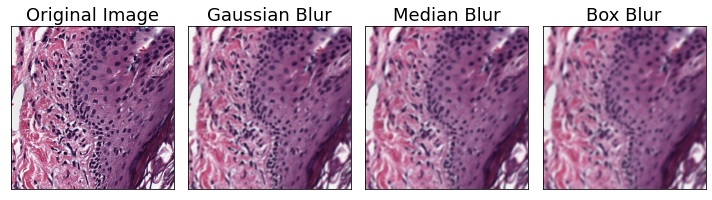

In [4]:
fig, axarr = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
ims = [tile_original, tile_gaussian, tile_median, tile_box]
titles = ["Original Image", "Gaussian Blur", "Median Blur", "Box Blur"]
for ax, im, title in zip(axarr.ravel(), ims, titles):
    ax.imshow(im)
    ax.set_title(title, fontsize = 18)
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

Let's compare the effect of different kernel widths for each of the transforms.

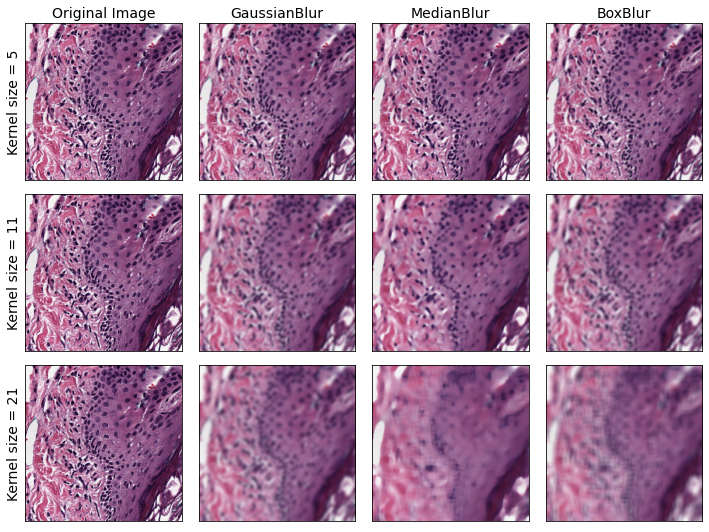

In [5]:
blurs = ["Original Image", GaussianBlur, MedianBlur,BoxBlur]
blur_name = ["Original Image", "GaussianBlur", "MedianBlur", "BoxBlur"]
k_size = [5, 11, 21]
fig, axarr = plt.subplots(nrows=3, ncols=4, figsize=(10, 7.5))
fontsize = 14
for i, kernel_size in enumerate(k_size):
    for j, blur in enumerate(blurs):
        tile = Tile(region, name = "testregion", slidetype=type(wsi))
        if blur != "Original Image":
            b = blur(kernel_size = kernel_size)
            b.apply(tile)
        ax = axarr[i, j]
        ax.imshow(tile.image)
        if i == 0:
            ax.set_title(blur_name[j], fontsize=fontsize)  
        if j == 0:
            ax.set_ylabel(f"Kernel size = {kernel_size}", fontsize = fontsize)        
for a in axarr.ravel():
    a.set_xticks([])
    a.set_yticks([])
plt.tight_layout()
plt.show() 

#### Stain Normalization 
*StainNormalizationHE* normalizes and separates hematoxylin and eosin stains.

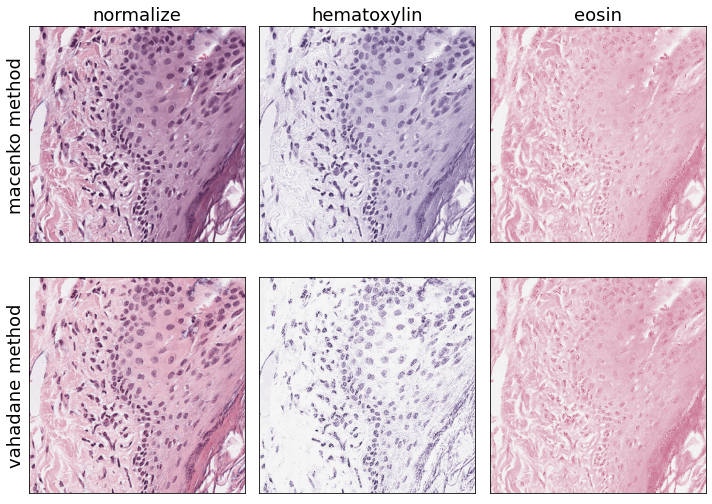

In [6]:
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(10, 7.5))
fontsize = 18
for i, method in enumerate(["macenko", "vahadane"]):
    for j, target in enumerate(["normalize", "hematoxylin", "eosin"]):
        tile = Tile(region, name = "testregion", slidetype=type(wsi))
        normalizer = StainNormalizationHE(target = target, stain_estimation_method = method)
        normalizer.apply(tile)
        ax = axarr[i, j]
        ax.imshow(tile.image)
        if j == 0:
            ax.set_ylabel(f"{method} method", fontsize=fontsize)
        if i == 0:
            ax.set_title(target, fontsize = fontsize)
for a in axarr.ravel():
    a.set_xticks([])
    a.set_yticks([])
plt.tight_layout()
plt.show()

#### Superpixel Interpolation
Divide input image into superpixels using SLIC algorithm, then interpolate each superpixel with average color. SLIC superpixel algorithm described in Achanta et al. 2012.

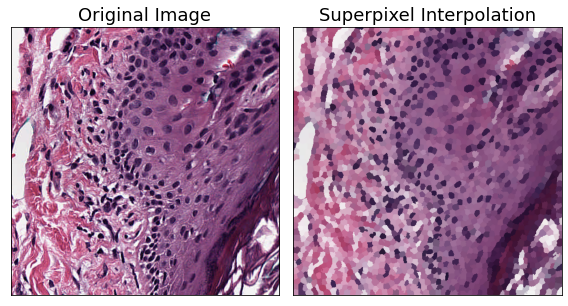

In [34]:
tile_original = tile.image.copy()
SuperpixelInterpolation().apply(tile)
superpixel = tile.image.copy()
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
ims = [tile_original, superpixel]
titles = ["Original Image", "Superpixel Interpolation"]
for ax, im, title in zip(axarr.ravel(), ims, titles):
    ax.imshow(im)
    ax.set_title(title, fontsize = 18)
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

#### Nucleus Detection
This transform employs a simple nucleus detection algorithm for H&E stained images. It works by first separating hematoxylin channel, then doing interpolation using superpixels, and finally using Otsu’s method for binary thresholding.

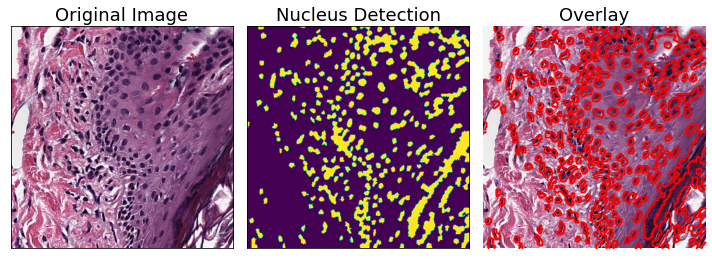

In [35]:
NucleusDetectionHE(mask_name = "detect_nuclei").apply(tile)
segmented = tile.masks["detect_nuclei"].copy()
fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
ims = [tile_original, segmented]
titles = ["Original Image", "Nucleus Detection", "Overlay"]
plot_mask(im = tile_original, mask_in=tile.masks["detect_nuclei"], ax = axarr[2])
axarr[0].imshow(tile_original)
axarr[1].imshow(segmented)
for ax, title in zip(axarr.ravel(), titles):
    ax.set_title(title, fontsize = 18)
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

#### Binary Threshold
The *Binary Threshold* transform operates on a Tile and creates a binary mask. If input image is RGB it is first converted to greyscale, otherwise the input must have 1 channel.



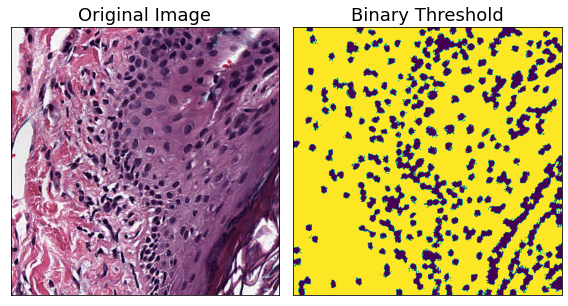

In [66]:
BinaryThreshold(mask_name = "bi_threshold", threshold = 20).apply(tile)
binary_threshold = tile.masks["bi_threshold"].copy()
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
ims = [tile_original, binary_threshold]
titles = ["Original Image", "Binary Threshold"]
for ax, im, title in zip(axarr.ravel(), ims, titles):
    ax.imshow(im)
    ax.set_title(title, fontsize = 18)
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

### For the following transforms, we'll use a Tile created from a larger region of the slide

In [36]:
bigregion = wsi.slide.extract_region(location = (800, 800), size = (1000, 1000))
bigtile = Tile(bigregion, name = "testregion", slidetype=type(wsi))
original = bigtile.image.copy()

#### Foreground Detection

This transform operates on binary masks and identifies regions that have a total area greater than specified threshold. Supports including holes within foreground regions, or excluding holes above a specified area threshold.

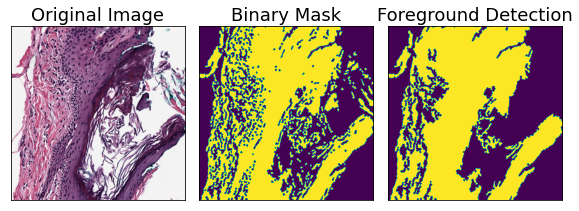

In [71]:
NucleusDetectionHE(mask_name = "createbinary").apply(bigtile)
segmented = bigtile.masks["createbinary"].copy()
ForegroundDetection(mask_name = "createbinary").apply(bigtile)
foreground = bigtile.masks["createbinary"].copy()
fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(8, 8))
ims = [original, segmented, foreground]
titles = ["Original Image", "Binary Mask", "Foreground Detection"]
for ax, im, title in zip(axarr.ravel(), ims, titles):
    ax.imshow(im)
    ax.set_title(title, fontsize = 18)
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

#### Tissue Detection
Detect tissue regions from H&E stained slide. First applies a median blur, then binary thresholding, then morphological opening and closing, and finally foreground detection.

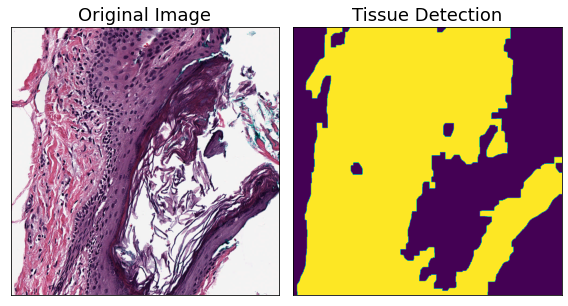

In [44]:
TissueDetectionHE(mask_name = "tissuebig").apply(bigtile)
tissue = bigtile.masks["tissuebig"].copy()
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
ims = [original, tissue]
titles = ["Original Image", "Tissue Detection"]
for ax, im, title in zip(axarr.ravel(), ims, titles):
    ax.imshow(im)
    ax.set_title(title, fontsize = 18)
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

#### Morphological Closing

First applies dilation operation, then erosion. Reduces noise by closing small holes in the foreground. Operates on a binary mask.



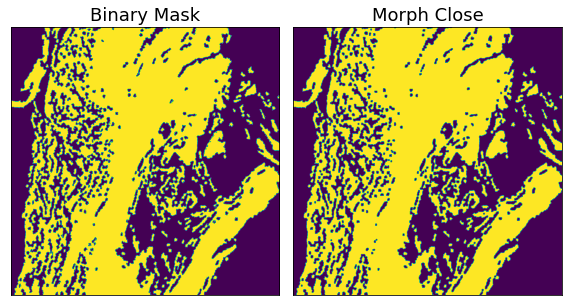

In [62]:
NucleusDetectionHE(mask_name = "new2").apply(bigtile)
binarymask = bigtile.masks["new2"].copy()
MorphClose(mask_name = "new2").apply(bigtile)
morph_close = bigtile.masks["new2"].copy()
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
ims = [binarymask, morph_close]
titles = ["Binary Mask", "Morph Close"]
for ax, im, title in zip(axarr.ravel(), ims, titles):
    ax.imshow(im)
    ax.set_title(title, fontsize = 18)
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

#### Morphological Opening

First applies erosion operation, then dilation. Reduces noise by removing small objects from the background. Operates on a binary mask.



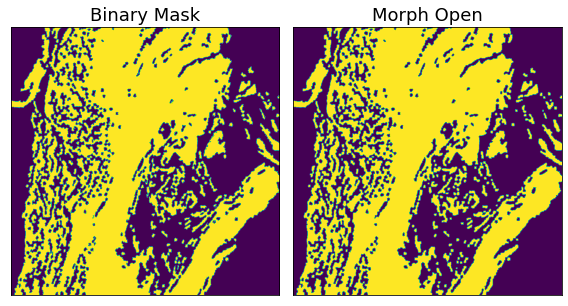

In [63]:
NucleusDetectionHE(mask_name = "test1").apply(bigtile)
binary1 = bigtile.masks["test1"].copy()
MorphOpen(mask_name = "test1").apply(bigtile)
morph_open = bigtile.masks["test1"].copy()
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
ims = [binary1, morph_open]
titles = ["Binary Mask", "Morph Open"]
for ax, im, title in zip(axarr.ravel(), ims, titles):
    ax.imshow(im)
    ax.set_title(title, fontsize = 18)
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

#### Let's compare the effect of multiple iterations on MorphClose and MorphOpen



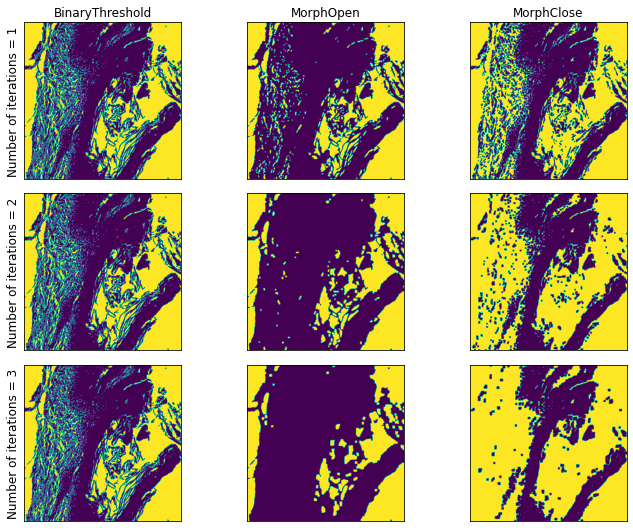

In [74]:
effects = [BinaryThreshold, MorphOpen, MorphClose]
edit_name = ["BinaryThreshold", "MorphOpen", "MorphClose"]
number = [1, 2, 3]
fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(10, 7.5))
fontsize = 12
for i, n_iter in enumerate(number):
    for j, effect in enumerate(effects):
        bigtile = Tile(bigregion, name = "bigregion", slidetype=type(wsi))
        newthreshold = BinaryThreshold(mask_name = "newthreshold", threshold = 10)
        newthreshold.apply(bigtile)
        if effect != BinaryThreshold:
            e = effect(mask_name = "newthreshold", n_iterations = n_iter)
            e.apply(bigtile)
        ax = axarr[i, j]
        ax.imshow(bigtile.masks["newthreshold"])
        if i == 0:
            ax.set_title(edit_name[j], fontsize=fontsize)  
        if j == 0:
            ax.set_ylabel(f"Number of iterations = {n_iter}", fontsize = fontsize)        
for a in axarr.ravel():
    a.set_xticks([])
    a.set_yticks([])
plt.tight_layout()
plt.show()